In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
import plotly
plotly.tools.set_credentials_file(username='jerkyhips', api_key='2iW3Grhgc8NpUmjqSctc')

### Chargement des données

In [2]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

### Exploration des données

In [3]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [8]:
pos_train.head(10)

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940
5,39.730417,-104.968940
6,39.693102,-105.006995
7,39.693102,-105.006995
8,39.693102,-105.006995
9,39.693102,-105.006995


In [30]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [6]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message
len(listOfBs)

259

In [7]:
listOfBs

array([  879,   911,   921,   944,   980,  1012,  1086,  1092,  1120,
        1131,  1148,  1156,  1187,  1226,  1229,  1235,  1237,  1264,
        1266,  1268,  1292,  1334,  1344,  1432,  1443,  1447,  1463,
        1476,  1526,  1530,  1534,  1581,  1594,  1661,  1730,  1741,
        1743,  1772,  1796,  1826,  1828,  1838,  1852,  1854,  1859,
        1872,  1878,  1971,  1987,  1988,  1994,  1996,  2189,  2293,
        2605,  2610,  2611,  2617,  2693,  2707,  2731,  2737,  2762,
        2765,  2766,  2768,  2770,  2775,  2776,  2780,  2784,  2790,
        2799,  2800,  2803,  2808,  2831,  2836,  2837,  2841,  2842,
        2845,  2846,  2849,  2855,  2862,  2943,  2945,  2999,  3025,
        3034,  3041,  3051,  3256,  3357,  3378,  3385,  3386,  3389,
        3402,  3403,  3410,  3412,  3414,  3415,  3500,  3501,  3515,
        3526,  3527,  3529,  3535,  3536,  3538,  3544,  3545,  3546,
        3547,  3548,  3549,  3553,  3554,  3555,  3556,  3558,  3559,
        3562,  3563,

In [63]:
len(df_mess_train["did"].unique())
len(df_mess_train["messid"].unique())
len(df_mess_train["bsid"].unique())

251

Le data set d'apprentissage est constitué de 
- 113 devices uniques
- 251 stations
- 6068 messages uniques
- 39250 messages

In [69]:
len(df_mess_test["did"].unique())
len(df_mess_test["messid"].unique())
len(df_mess_test["bsid"].unique())

168

In [53]:
stations_of_test = np.setdiff1d(np.unique(df_mess_test['bsid']), np.unique(df_mess_train['bsid']) )
stations_of_test

array([1131, 3034, 3828, 8168, 9783, 9936, 9941, 9949])

In [54]:
dummy_stations_test = pd.DataFrame(np.zeros((len(df_mess_train),len(stations_of_test))), columns=stations_of_test)

In [70]:
df_work = df_mess_train.copy()
# On ajoute au train set des colonnes
one_hot = pd.get_dummies(df_work['bsid'])
df_work = df_work.join(one_hot)
df_work = pd.concat([df_work,dummy_stations_test], axis=1)
#df_work.sort_values(by=["messid","bsid"])
df_work = df_work.set_index("messid")
df_work = df_work[~df_work.index.duplicated(keep='first')]
df_work = df_work.drop(["bsid","did","time_ux", "nseq", "rssi","bs_lat","bs_lng"], axis=1)
df_work.head()

,879,911,921,944,980,1012,1086,1092,1120,1148,...,11007,11951,1131,3034,3828,8168,9783,9936,9941,9949
messid,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573bf3533e952e19126b256a,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c0cd0f0fe6e735a699b93,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c1272f0fe6e735a6cb8bd,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c8ea8864fce1a9a5fbf7a,0,0,0,0,0,0,1,0,0,0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_work = df_mess_train.copy()
df_work2 = df_work.pivot(index="messid", columns="bsid", values=["rssi","nseq","bs_lat","bs_lng"])
df_work2 = df_work2.fillna(value=0)
df_work2 = df_work2.swaplevel(axis=1)
df_work2 = df_work2.sort_index(by="bsid", axis=1)
df_work2.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """


bsid                     879                       911                     \
                          rssi nseq bs_lng bs_lat bs_lng nseq rssi bs_lat   
messid                                                                      
573bf1d9864fce1a9af8c5c9   0.0  0.0    0.0    0.0    0.0  0.0  0.0    0.0   
573bf3533e952e19126b256a   0.0  0.0    0.0    0.0    0.0  0.0  0.0    0.0   
573c0cd0f0fe6e735a699b93   0.0  0.0    0.0    0.0    0.0  0.0  0.0    0.0   
573c1272f0fe6e735a6cb8bd   0.0  0.0    0.0    0.0    0.0  0.0  0.0    0.0   
573c8ea8864fce1a9a5fbf7a   0.0  0.0    0.0    0.0    0.0  0.0  0.0    0.0   

bsid                     921           ...   10999       11007              \
                          nseq bs_lng  ...    rssi nseq bs_lat bs_lng nseq   
messid                                 ...                                   
573bf1d9864fce1a9af8c5c9   0.0    0.0  ...     0.0  0.0    0.0    0.0  0.0   
573bf3533e952e19126b256a   0.0    0.0  ...     0.0  0.0    0.0    0.0  0.0   
573c0cd0f0fe6e735a699b93   0.0    0.0  ...     0.0  0.0    0.0    0.0  0.0   
573c1272f0fe6e735a6cb8bd   0.0    0.0  ...     0.0  0.0    0.0    0.0  0.0   
573c8ea8864fce1a9a5fbf7a   0.0    0.0  ...     0.0  0.0    0.0    0.0  0.0   

bsid                          11951                     
                         rssi  nseq rssi bs_lat bs_lng  
messid                                                  
573bf1d9864fce1a9af8c5c9  0.0   0.0  0.0    0.0    0.0  
573bf3533e952e19126b256a  0.0   0.0  0.0    0.0    0.0  
573c0cd0f0fe6e735a699b93  0.0   0.0  0.0    0.0    0.0  
573c1272f0fe6e735a6cb8bd  0.0   0.0  0.0    0.0    0.0  
573c8ea8864fce1a9a5fbf7a  0.0   0.0  0.0    0.0    0.0  

[5 rows x 1004 columns]

In [32]:
#df_work2.loc[:, (2841,slice(None))]

Le data set d'apprentissage est constitué de 
- 56 devices uniques
- 168 stations différentes, mais en fait seulement 8 stations de plus que jeu d'apprentissage
- 5294 messages uniques
- 29286 messages

### Construction de la matrice de features

In [27]:
# Feature Matrix construction
def feat_mat_const(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(
        ['messid'], as_index=False)  # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess, len(listOfBs))),
                           columns=listOfBs)  # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx, df_mess_bs_group.get_group(key)['bsid']] = 1
        id_list[idx] = key
        idx = idx + 1

    return df_feat, id_list  # add id value of each message for the correspondance to message

Text(0.5,1,'Histogramme des messages reçus par station')

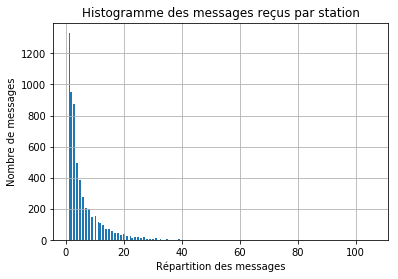

In [70]:
df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) 
df_mess_bs_group.count().sort_values(by='bsid',ascending=False)["bsid"].hist(bins=200)
plt.xlabel("Répartition des messages")
plt.ylabel("Nombre de messages")
plt.title("Histogramme des messages reçus par station")

In [67]:
#df_feat, id_list_train = feat_mat_const(df_mess_train, listOfBs)
#df_feat.describe()
df_feat = df_work

In [4]:
# ground truth construction
def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return np.array([ground_truth_lat, ground_truth_lng]).T

In [5]:
ground_truth = ground_truth_const(df_mess_train, pos_train)
ground_truth.shape

(6068, 2)

In [6]:
import plotly.plotly as py
import plotly.graph_objs as go

mapbox_access_token = 'pk.eyJ1IjoiamVya3loaXBzIiwiYSI6ImNqcG4zNXY1ejBqczg0Mm1rNzFtcndnOWgifQ.Nk5O1jFijCouBByXtCs05w'

data = [
    go.Scattermapbox(
        lat=ground_truth[:,0],
        lon=ground_truth[:,1],
        mode='markers',
        marker=dict(
            size=9
        ),
    )]

layout = go.Layout(
    title='Ground truth messages position',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=38,
            lon=-94
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jerkyhips/0 or inside your plot.ly account where it is named 'Multiple Mapbox'


In [13]:
ground_truth[:,0]

array([39.60668952, 39.63774123, 39.73041743, ..., 39.77887196,
       39.77326419, 39.90818599])

In [7]:
station_train_pos = df_mess_train.groupby("bsid").mean()[["bs_lat","bs_lng"]]
station_test_pos = df_mess_test.groupby("bsid").mean()[["bs_lat","bs_lng"]]

In [10]:
import plotly.plotly as py
import plotly.graph_objs as go

mapbox_access_token = 'pk.eyJ1IjoiamVya3loaXBzIiwiYSI6ImNqcG4zNXY1ejBqczg0Mm1rNzFtcndnOWgifQ.Nk5O1jFijCouBByXtCs05w'

data = [
    go.Scattermapbox(
        lat=station_train_pos["bs_lat"],
        lon=station_train_pos["bs_lng"],
        mode='markers',
        marker=dict(
            size=9,
            color='rgb(255, 0, 0)'
        ),
        text=station_train_pos.index,
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=station_test_pos["bs_lat"],
        lon=station_test_pos["bs_lng"],
        mode='markers',
        marker=dict(
            size=9,
            color='rgb(0, 0, 255)'
        ),
        text=station_test_pos.index,
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=ground_truth[:,0],
        lon=ground_truth[:,1],
        mode='markers',
        marker=dict(
            size=9,
            color='rgb(0, 255, 0)'
        ),)]

layout = go.Layout(
    title='Stations position',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=38,
            lon=-94
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jerkyhips/0 or inside your plot.ly account where it is named 'Multiple Mapbox'


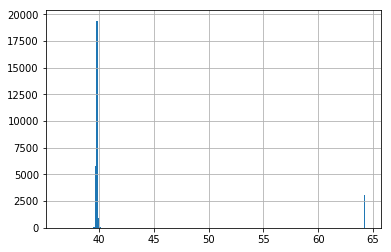

In [59]:

df_mess_test["bs_lat"].hist(bins=200)


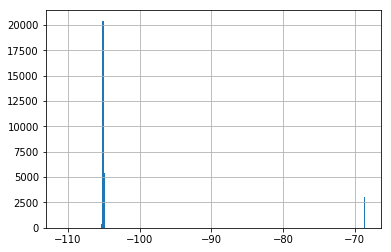

In [53]:
df_mess_test["bs_lng"].hist(bins=200)

### Modèle de prédiction

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_feat, ground_truth, test_size=0.2, random_state=42)

In [15]:
def regressor_and_predict(X_train, y_train, X_test, y_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    from sklearn.ensemble import RandomForestRegressor
    #reg = RandomForestRegressor(max_depth=20, random_state=0, n_estimators=100)
    
    from sklearn.svm import SVR
    reg = SVR(kernel='rbf',gamma='scale', C=1, epsilon=0.1)

    reg.fit(X_train, y_train[:,0]);
    y_pred_lat = reg.predict(X_test) 
    print("Score lat : ", reg.score(X_test,y_test[:,0]))
    
    reg.fit(X_train, y_train[:,1]);
    y_pred_lng = reg.predict(X_test)
    print("Score lng : ", reg.score(X_test,y_test[:,1]))
    
    return y_pred_lat, y_pred_lng


In [16]:
y_pred_lat, y_pred_lng = regressor_and_predict(X_train, y_train, X_test, y_test)

Score lat :  0.8472296634995862
Score lng :  0.8427022994106217


In [71]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.linear_model import ElasticNet

# Lasso 8105
#reg = linear_model.Lasso(alpha=0.05)
# RF 7500
#reg = RandomForestRegressor(max_depth=20, random_state=0, n_estimators=100)

# GBoost : 6250 / 4921 avec df_work
reg = GradientBoostingRegressor(loss="huber", n_estimators=300, subsample=0.7)
y_pred_lng = cross_val_predict(reg, df_feat, ground_truth[:,1], cv=5)
print("lng OK")
y_pred_lat = cross_val_predict(reg, df_feat, ground_truth[:,0], cv=5)
print("lat OK")

err_vec = Eval_geoloc(ground_truth[:,0] , ground_truth[:,1], y_pred_lat, y_pred_lng)
# Error criterion
np.percentile(err_vec, 80)

lng OK
lat OK


4923.84689050882

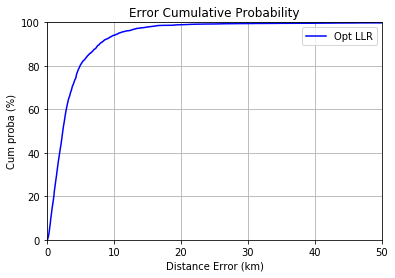

In [72]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 50, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [20]:
# Calcul de la distance en mètres entre 2 points GPS sur la Terre (Haversine formula)
def haversine(lat1, lon1, lat2, lon2):
    Radius_earth_km = 6371
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_km = Radius_earth_km * c
    return total_km * 1000

In [21]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    # Si on a des valeurs de latitudes supérieures à 90 ou inférieures à -90, on les ajuste
    y_pred_lat[np.where(y_pred_lat>90)[0]]=90
    y_pred_lat[np.where(y_pred_lat<-90)[0]]=-90
    err_vec = haversine(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng)
    
    return err_vec

In [25]:
# Construct test prediction

In [51]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [52]:
df_feat_test, id_list_test = feat_mat_const(df_mess_test, listOfBs)

In [124]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

Score lat :  1.0
Score lng :  1.0


In [54]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = id_list_test

In [55]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [56]:
test_res.head()

,lat,lng,messid
0,39.753648,-105.032251,573be2503e952e191262c351
1,39.753648,-105.032251,573c05f83e952e1912758013
2,39.753648,-105.032251,573c0796f0fe6e735a66deb3
3,39.753648,-105.032251,573c08d2864fce1a9a0563bc
4,39.753648,-105.032251,573c08ff864fce1a9a0579b0
